We are given a synthetic financial dataset generated using a simulator called PaySim in which some of the transactions are marked as fraudulent. Our task is to analyze the dataset by performing exploratory data analysis and finally train a suitable model to predict fraudulent financial transactions. 

**Dataset** - The dataset consists of almost 6.3 million rows of transacional data having 11 columns. The dataset is simulated version of real transactions extracted from one month of financial logs from a mobile money service implemented in an African country. Also, there are no missing values in the dataset.

In [ ]:
import pandas as pd
df = pd.read_csv('PS_20174392719_1491204439457_log.csv')
df.shape

(6362620, 11)

In [ ]:
print("Any missing values: {}".format(df.isnull().values.any()))
df.head(10)

Any missing values: False


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


To explain the data, we have the following columns:-

**Step:-** This represents an unit of time equal to 1 hr in real world. There are total 30days (744 steps) of simulation.

**Type:-** There are 5 types of transaction- CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

**Amount:-** The total amount of transaction that happened in local currency.

**nameOrig:-** Name of the customer who started the transaction

**oldbalanceOrg:-** Initial balance before the transaction at origin

**newbalanceOrig:-** New balance after the transaction at origin

**nameDest:-** Customer who is the recipient of the transaction

**oldbalanceDest:-** Initial balance before the transaction at destination.

**newbalanceDest:-** New balance after the transaction at destination. 

A thing to note is that there is no information for customers whose name start with M (Merchants).

**isFraud:-** This variable marks whether a transaction is fraud or not. 

**isFlaggedFraud:-** This variable denotes whether the business model was able to flag a transaction as fraud or not. An illegal attempt in this dataset is an attempt to transfer more than 200,000 in a single transaction.

**Issues with the dataset**

1. The main issue with the dataset is that it is highly imbalanced. The positive class outnumbers the negative class by a lot. We will need to account for this imbalanced data while training later. 

2. The variable **isFlaggedFraud** is not very useful as it doesn't quite relate with any other parameters. It appears to be true in only 16 transactions out of 6 million entries and doesn't add much value. Also, in some places the variable is very inconsistent with respect to its definition; where it said the flag should be set to true for a transaction more than 200,000 but it's not.

3. Finally, the dataset is sometimes inconsistent with respect to the transaction data. For example, in the above sample we can see for the 3rd transaction, 181.0 amount was Cashed Out but the transactional amount is not reflected at the destination column.

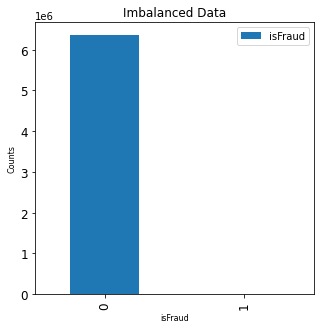

0    6354407
1       8213
Name: isFraud, dtype: int64


In [ ]:
import matplotlib.pyplot as plt
ax = df['isFraud'].value_counts().plot(kind='bar', title ="Imbalanced Data", figsize=(5, 5), legend=True, fontsize=12)
ax.set_xlabel("isFraud", fontsize=8)
ax.set_ylabel("Counts", fontsize=8)
plt.show()
print (df['isFraud'].value_counts())

We can see that the data is highly imbalanced as the number of negatives (isFraud=0) are much more than the number of positives (isFraud=1)

In [ ]:
df_flagged = df.loc[df['isFlaggedFraud']==1]
df_not_flagged = df.loc[df['isFlaggedFraud']==0]
print("Number of times isFlaggedFraud is set: {}".format(len(df_flagged)))
print("Max amount transacted when isFlaggedFraud not set: {}".format(df_not_flagged.amount.max()))

Number of times isFlaggedFraud is set: 16
Max amount transacted when isFlaggedFraud not set: 92445516.64


We can see here that the **isFlaggedFraud** variable is inconsistent as it appears only 16 times and it doesn't flag a transaction amount well above 200,000 as fraud. Hence, we will not be using this parameter in our further analysis.

**Visualizations**

1. Types of transactions

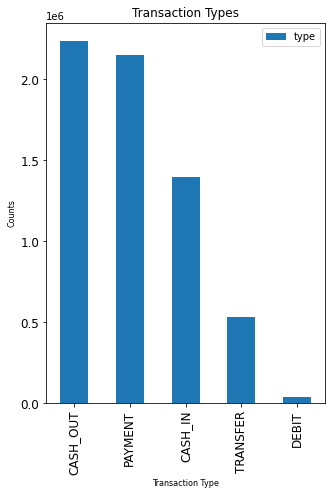

In [ ]:
ax = df['type'].value_counts().plot(kind='bar', title ="Transaction Types", figsize=(5, 7), legend=True, fontsize=12)
ax.set_xlabel("Transaction Type", fontsize=8)
ax.set_ylabel("Counts", fontsize=8)
plt.show()

We can observe that the most common transaction types are the CASH_OUT and PAYMENT modes.

2. Types of transactions where isFraud is True

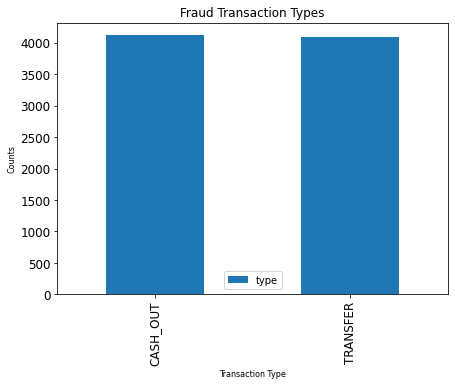

CASH_OUT    4116
TRANSFER    4097
Name: type, dtype: int64


In [ ]:
ax = df.loc[df['isFraud']==1, 'type'].value_counts().plot(kind='bar', title ="Fraud Transaction Types", figsize=(7, 5), legend=True, fontsize=12)
ax.set_xlabel("Transaction Type", fontsize=8)
ax.set_ylabel("Counts", fontsize=8)
plt.show()
print (df.loc[df['isFraud']==1, 'type'].value_counts())

We can observe that the fraudulent transactions happens only with the CASH_OUT and TRANSFER modes and hence, we are interested in these two types only for fraud prediction.

3. Amount vs Time for Fraudulent/Genuine transactions

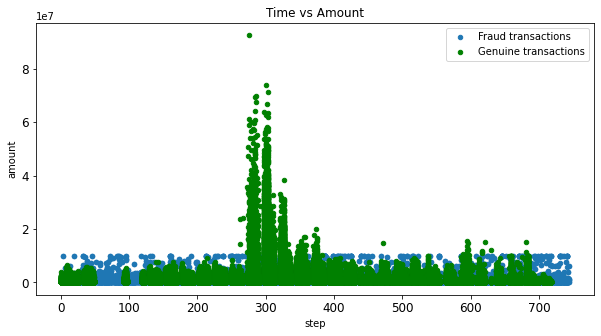

In [ ]:
df1 = df[(df.isFraud==1)]
df2 = df[(df.isFraud==0)]
ax1 = df1.plot(kind='scatter', x='step', y='amount',title ="Time vs Amount", figsize=(10, 5), label="Fraud transactions", legend=True, fontsize=12)
ax2 = df2.plot(kind='scatter', x='step', y='amount',title ="Time vs Amount", color='g',figsize=(10, 5), label="Genuine transactions", legend=True, fontsize=12,ax=ax1)
ax1.set_xlabel("Time Step", fontsize=8)
ax1.set_ylabel("Amount", fontsize=8)
plt.show()

We can observe that fraudulent transactions are capped at 10 million currency units but genuine transactions exceed over 92 million units.

4. Number of Fraud/genuine transactions per time step

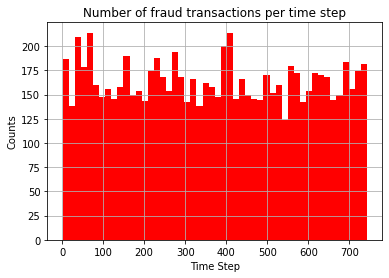

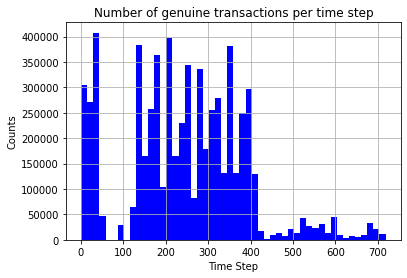

In [ ]:
df1 = df[(df.isFraud==1)]
df2 = df[(df.isFraud==0)]
bins=50

df1.hist(column="step",color="red",bins=bins)
plt.title("Number of fraud transactions per time step")
plt.xlabel("Time Step", fontsize=10)
plt.ylabel("Counts", fontsize=10)

df2.hist(column="step",color="blue",bins=bins)
plt.title("Number of genuine transactions per time step")
plt.xlabel("Time Step", fontsize=10)
plt.ylabel("Counts", fontsize=10)
plt.show()

We can see that fraudulent transactions happens at a constant rate through out the month but genuine transactions has no such pattern.

5. Old Balance in origin vs destination accounts

Text(0.5, 1.0, 'Frauduent Transactions')

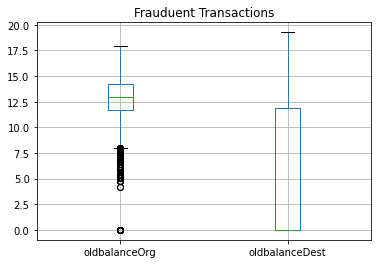

In [ ]:
import numpy as np
import warnings
warnings.filterwarnings("ignore")
df1 = df[(df.isFraud==1)]
df2 = df[(df.isFraud==0)]
df1.loc[:,'oldbalanceOrg'] = df1.oldbalanceOrg.apply(lambda x: np.log1p(x))
df1.loc[:,'oldbalanceDest'] = df1.oldbalanceDest.apply(lambda x: np.log1p(x))
df1.boxplot(column=['oldbalanceOrg','oldbalanceDest'])
plt.title("Frauduent Transactions")

Text(0.5, 1.0, 'Genuine Transactions')

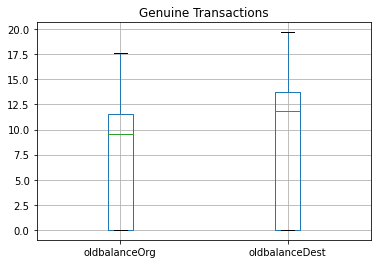

In [ ]:
df2.loc[:,'oldbalanceOrg'] = df2.oldbalanceOrg.apply(lambda x: np.log1p(x))
df2.loc[:,'oldbalanceDest'] = df2.oldbalanceDest.apply(lambda x: np.log1p(x))
df2.boxplot(column=['oldbalanceOrg','oldbalanceDest'])
plt.title("Genuine Transactions")

From the above, we can see that for fraudulent transactions, the old balance in origin account is significantly higher thant the old balance in destination account. This shows that money is being stolen from a richer account to a new/poor account.

**Feature Engineering and Data Cleansing**


We have seen that there are no null values in the dataset. But there are lot of zeros which we can assume as being the static fill value of any missing data.

For the first step of data cleaning, we will need to keep only the types 'CASH_OUT' and 'TRANSFER' as they are the only types with fraudulent transactions.

Secondly, we need to one hot encode the 'type' data so that we get a 0 or 1 encoding from the corresponding string representations.

Thirdly, we also add a feature 'hourOfDay' to keep note of the time when fraudulent transactions happen. This is because we saw above the genuine transactions doesnt happen always but fraud transactions occurs at a constant rate.

Finally, we are adding two new features that is important towards extracting the best results from the ML algorithms: 'errorBalanceOrig' and 'errorBalanceDest'. These features denotes the respective error values between origin/destination balance values.



In [ ]:
from random import seed,sample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, roc_curve, auc,\
precision_score
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

In [ ]:
#Preparing X and Y datasets
X = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]
Y = X['isFraud']
X = X.drop("isFraud",1)
X = X.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

# adding feature HourOfDay 
X["HourOfDay"] = np.nan # initializing feature column
X.HourOfDay = X.step % 24

#adding errorbalanceOrf feature
X["errorBalanceOrg"] = X.newbalanceOrig + X.amount - X.oldbalanceOrg
X["errorBalanceDest"] = X.oldbalanceDest + X.amount - X.newbalanceDest

#One hot encoding
X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.type = X.type.astype(int)

#Setting seed values
randomState = 42
seed(21)

#using default 75% train, 25% test split
X_train, X_test, y_train, y_test = train_test_split(X, Y)

#Normalizing data
scaler = StandardScaler()

# Fitting the training data
scaler.fit(X_train)

# Applying the transformations to the data:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)



I have tried the two best models that works pretty good for imbalanced data.

1. **Random Forests:-** The reason for choosing random forests is that weights can be assigned to majority class to reduce the bias towards that class. Since our data is imbalanced and more skewed towards the positive class (non fraud), this model works well here.

2. **Gradient Boosting (XGB):-** This model is similar to random forests with an additional advantage being it pools the results from multiple decision trees generated sequentially (as compared to parallely in Random Forests). Hence, the model is bit slower but it is more accurate.

In [ ]:
#Algorithm 1 - Random Forests

#Train
paramsrf = {'n_estimators':15,'oob_score':True,'class_weight': "balanced",'n_jobs':-1,'random_state':randomState}

RF = RandomForestClassifier(**paramsrf)
fit_vals_rf = RF.fit(X_train, y_train)

# Prediction
pred_rf = RF.predict(X_test)

# Evaluation
cm_rf = confusion_matrix(y_test,pred_rf)
cl_report_rf = classification_report(y_test,pred_rf)
fprrf, recallrf, thresholdsrf = roc_curve(y_test, pred_rf)
aucrf = auc(fprrf, recallrf)

resultsrf = {"Confusion Matrix":cm_rf,"Classification Report":cl_report_rf,"Area Under Curve":aucrf}

In [ ]:
#print results
for i in resultsrf:
    print(i,": \n",resultsrf[i])

Confusion Matrix : 
 [[690573      1]
 [     8   2021]]
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    690574
           1       1.00      1.00      1.00      2029

    accuracy                           1.00    692603
   macro avg       1.00      1.00      1.00    692603
weighted avg       1.00      1.00      1.00    692603

Area Under Curve : 
 0.9980278614747358


In [ ]:
#Algorithm 2 - XGB Trees

# Train
weights = (Y == 0).sum() / (1.0 * (Y == 1).sum()) # recommended weights for unbalanced dataset
paramsxgb = {'max_depth':3,'scale_pos_weight': weights,'n_jobs':-1,'random_state':randomState,'learning_rate':0.1}
XGB = XGBClassifier(**paramsxgb)
    
fit_valsxgb = XGB.fit(X_train, y_train)
 
# Prediction
predxgb = XGB.predict(X_test)
 
     
# Evaluating model
cmxgb = confusion_matrix(y_test,predxgb)
crxgb = classification_report(y_test,predxgb)
fprxgb, recallxgb, thresholdsxgb = roc_curve(y_test, predxgb)
aucxgb = auc(fprxgb, recallxgb)
resultsxgb = {"Confusion Matrix":cmxgb,"Classification Report":crxgb,"Area Under Curve":aucxgb}

In [ ]:
#print results
for i in resultsxgb:
    print(i,": \n",resultsxgb[i])


Confusion Matrix : 
 [[690367    207]
 [     6   2023]]
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    690574
           1       0.91      1.00      0.95      2029

    accuracy                           1.00    692603
   macro avg       0.95      1.00      0.97    692603
weighted avg       1.00      1.00      1.00    692603

Area Under Curve : 
 0.998371563811468


To compare the performances of both the models, we need to compare their confusion matrices.

Number of valid transactions labelled as fraudulent by Random Forest: 
 29
Number of valid transactions labelled as fraudulent by XGB trees: 
 12817

Number of fraud transactions labelled as valid by Random Forest: 
 392
Number of fraud transactions labelled as valid by XGB trees: 
 23

The better model is dependent on which of the above result is acceptable to us. According to me, the number of valid transactions labelled as fraudulent by XGB trees is way high. Therefore, according to me, Random Forests is the superior model here.

We have also computed the AUC (Area Under Curve) to compare the performance where the XGB model has worked better. The curve in Area Under Curve is a plot of the true positive rates (in our case, the proportion of valid transactions labelled as valid) against the false positive rate (in our case, the proportion of fraudulent transactions labelled as valid). The curve is also known as the Receiver Operating Characteristic Curve or ROC.

The plot of ROC curve can be seen below.


Receiver Operating Characteristic Curves for Random Forests and Extreme Gradient Boosted Trees: 



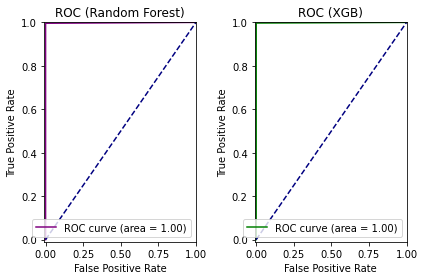


AUC of Random Forest: 
 0.9980278614747358

AUC of XGB trees: 
 0.998371563811468


In [ ]:
print("\nReceiver Operating Characteristic Curves for Random Forests and Extreme Gradient Boosted Trees: \n")
plt.subplot(1, 2, 1)
plt.plot(fprrf, recallrf, color='purple', label='ROC curve (area = %0.2f)' % aucrf)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (Random Forest)')
plt.legend(loc="lower right")


plt.subplot(1, 2, 2)
plt.plot(fprxgb, recallxgb, color='green', label='ROC curve (area = %0.2f)' % aucxgb)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (XGB)')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

print("\nAUC of Random Forest: \n", aucrf)
print("\nAUC of XGB trees: \n", aucxgb)

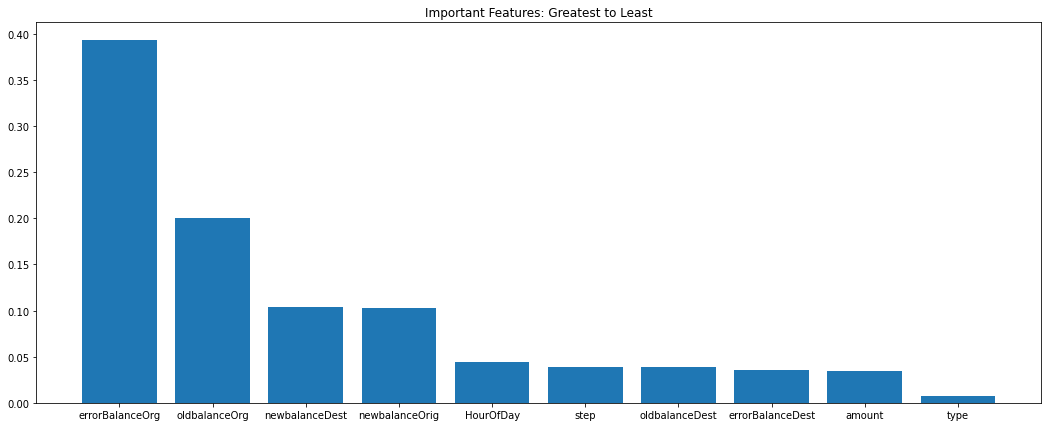

In [ ]:
#Feature Importance
x = np.arange(len(X.columns))

# getting importances of features
importances = RF.feature_importances_

# getting the indices of the most important feature to least important
sort_ind = np.argsort(importances)[::-1]
plt.figure(figsize=(18,7))
plt.bar(x, importances[sort_ind])
plt.xticks(x,tuple(X.columns.values[sort_ind]))
plt.title("Important Features: Greatest to Least")
plt.show()

As said earlier, we can see that the 'errorBalanceOrg' feature has the highest importance because it denotes the differences between net origin balance and net destination balance which is most accurately related to the transaction being flagged as fraud or not.

**Improvement:** We can improve our results by also looking for approaches like undersampling the majority class or oversampling the minority class (SMOTE-preffered) and then use native classifiers like Logistic Regression on the balanced data.